# Figure: How large should effect sizes be in neuroimaging to have sufficient power?

### Specification of alternative

In a brain map in an MNI template, with smoothness of 3 times the voxelsize, there is one active region with voxelwise effect size D.  The (spatial) size of the region is relatively small (<200 voxels).  We want to know how large D should be in order to have 80% power to detect the region using voxelwise FWE thresholding using Random Field Theory.
Detect the region means that the maximum in the activated area exceeds the significance threshold.

### Strategy

1. Compute the voxelwise threshold for the specified smoothness and volume 
    * _FweThres = 5.12_
2. Define the alternative hypothesis, so that the omnibus power is 80% 
3. How large should the maximum statistic in a (small) region be to exceed the voxelwise threshold with 0.8 power? 
    * _muMax = 4.00_
5. How does this voxel statistic translate to Cohen's D for a given sample size?
    * _See Figure_

In [43]:
% matplotlib inline
from __future__ import division
import os
import nibabel as nib
import numpy as np
from neuropower import peakdistribution
import scipy.integrate as integrate
import pandas as pd
import matplotlib.pyplot as plt
import palettable.colorbrewer as cb

if not 'FSLDIR' in os.environ.keys():
    raise Exception('This notebook requires that FSL is installed and the FSLDIR environment variable is set')



## 1. What is the voxelwise threshold?

In [44]:
# From smoothness + mask to ReselCount

FWHM = 3
ReselSize = FWHM**3
MNI_mask = nib.load(os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain_mask.nii.gz')).get_data()
Volume = np.sum(MNI_mask)
ReselCount = Volume/ReselSize

print("ReselSize: "+str(ReselSize))
print("Volume: "+str(Volume))
print("ReselCount: "+str(ReselCount))
print("------------")

# From ReselCount to FWE treshold

FweThres_cmd = 'ptoz 0.05 -g %s' %ReselCount
FweThres = os.popen(FweThres_cmd).read()

print("FWE voxelwise GRF threshold: "+str(FweThres))

ReselSize: 27
Volume: 228483
ReselCount: 8462.33333333
------------
FWE voxelwise GRF threshold: 5.123062



## 2. Definition of alternative

#### Detect 1 region
We define a 'success' as a situation in which the maximum in the active field exceeds
the threshold.

In [45]:
Power = 0.8

## 3. How large statistic in a field be to exceed the threshold with power 0.80?

We quantify this by computing the expected local maximum in the field (which is a null field elevated by value D).
We use the distribution of local maxima of Cheng&Schwartzman to compute the power/effect size.

In [46]:
muRange = np.arange(1.8,5,0.01)
muSingle = []
for muMax in muRange:
# what is the power to detect a maximum 
    power = 1-integrate.quad(lambda x:peakdistribution.peakdens3D(x,1),-20,float(FweThres)-muMax)[0]
    if power>Power:
        muSingle.append(muMax)
        break
print("The power is sufficient for one region if mu equals: "+str(muSingle[0]))

The power is sufficient for one region if mu equals: 4.0


## 5. From the required voxel statistic to Cohen's D for a given sample size

In [47]:
# Read in data
Data = pd.read_csv("../SampleSize/neurosynth_study_data.txt",sep=" ",header=None,names=['year','n'])
Data['source']='Tal'
Data=Data[Data.year!=1997] #remove year with 1 entry
David = pd.read_csv("../SampleSize/david_sampsizedata.txt",sep=" ",header=None,names=['year','n'])
David['source']='David'
Data=Data.append(David)

In [48]:
# add detectable effect
Data['deltaSingle']=muSingle[0]/np.sqrt(Data['n'])

In [49]:
# add jitter for figure
stdev = 0.01*(max(Data.year)-min(Data.year))
Data['year_jitter'] = Data.year+np.random.randn(len(Data))*stdev

In [50]:
# Compute medians per year (for smoother)
Medians = pd.DataFrame({'year':
                     np.arange(start=np.min(Data.year),stop=np.max(Data.year)+1),
                      'TalMdSS':'nan',
                     'DavidMdSS':'nan',
                      'TalMdDSingle':'nan',
                     'DavidMdDSingle':'nan',
                        'MdSS':'nan',
                        'DSingle':'nan'
                       })

In [51]:
for yearInd in (range(len(Medians))):
    # Compute medians for Tal's data
    yearBoolTal = np.array([a and b for a,b in zip(Data.source=="Tal",Data.year==Medians.year[yearInd])])
    Medians.TalMdSS[yearInd] = np.median(Data.n[yearBoolTal])
    Medians.TalMdDSingle[yearInd] = np.median(Data.deltaSingle[yearBoolTal])
    # Compute medians for David's data
    yearBoolDavid = np.array([a and b for a,b in zip(Data.source=="David",Data.year==Medians.year[yearInd])])
    Medians.DavidMdSS[yearInd] = np.median(Data.n[yearBoolDavid])
    Medians.DavidMdDSingle[yearInd] = np.median(Data.deltaSingle[yearBoolDavid])
    # Compute medians for all data
    yearBool = np.array(Data.year==Medians.year[yearInd])
    Medians.MdSS[yearInd] = np.median(Data.n[yearBool])
    Medians.DSingle[yearInd] = np.median(Data.deltaSingle[yearBool])   


/Users/poldrack/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/poldrack/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/poldrack/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/poldrack/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentat

In [52]:
Medians[0:5]

,DSingle,DavidMdDSingle,DavidMdSS,MdSS,TalMdDSingle,TalMdSS,year
0,1.26491,1.26491,10,10,NaN,NaN,1996.0
1,1.20605,1.20605,11,11,NaN,NaN,1997.0
2,1.13205,1.13205,12.5,12.5,NaN,NaN,1998.0
3,1.41421,1.41421,8,8,NaN,NaN,1999.0
4,1.23548,1.23548,10.5,10.5,NaN,NaN,2000.0


In [53]:
# add logscale

Medians['MdSSLog'] = [np.log(x) for x in Medians.MdSS]
Medians['TalMdSSLog'] = [np.log(x) for x in Medians.TalMdSS]
Medians['DavidMdSSLog'] = [np.log(x) for x in Medians.DavidMdSS]

Data['nLog']= [np.log(x) for x in Data.n]

## The figure per List (Tal or David)

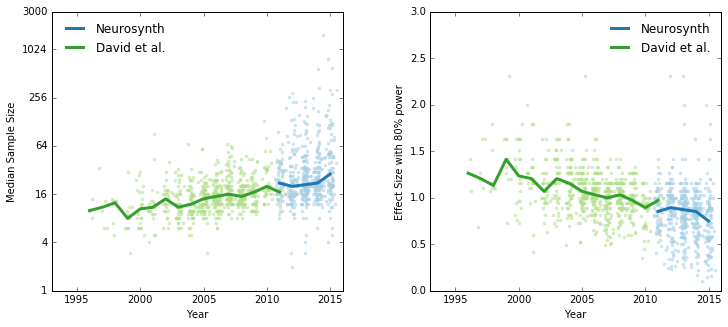

In [54]:
twocol = cb.qualitative.Paired_12.mpl_colors

fig,axs = plt.subplots(1,2,figsize=(12,5))
fig.subplots_adjust(hspace=.5,wspace=.3)
axs=axs.ravel()
axs[0].plot(Data.year_jitter[Data.source=="Tal"],Data['nLog'][Data.source=="Tal"],"r.",color=twocol[0],alpha=0.5,label="")
axs[0].plot(Data.year_jitter[Data.source=="David"],Data['nLog'][Data.source=="David"],"r.",color=twocol[2],alpha=0.5,label="")
axs[0].plot(Medians.year,Medians.TalMdSSLog,color=twocol[1],lw=3,label="Neurosynth")
axs[0].plot(Medians.year,Medians.DavidMdSSLog,color=twocol[3],lw=3,label="David et al.")
axs[0].set_xlim([1993,2016])
axs[0].set_ylim([0,8])
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Median Sample Size")
axs[0].legend(loc="upper left",frameon=False)
#labels=[1,5,10,20,50,150,500,1000,3000]
labels=[1,4,16,64,256,1024,3000]
axs[0].set_yticks(np.log(labels))
axs[0].set_yticklabels(labels)


axs[1].plot(Data.year_jitter[Data.source=="Tal"],Data.deltaSingle[Data.source=="Tal"],"r.",color=twocol[0],alpha=0.5,label="")
axs[1].plot(Data.year_jitter[Data.source=="David"],Data.deltaSingle[Data.source=="David"],"r.",color=twocol[2],alpha=0.5,label="")
axs[1].plot(Medians.year,Medians.TalMdDSingle,color=twocol[1],lw=3,label="Neurosynth")
axs[1].plot(Medians.year,Medians.DavidMdDSingle,color=twocol[3],lw=3,label="David et al.")
axs[1].set_xlim([1993,2016])
axs[1].set_ylim([0,3])
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Effect Size with 80% power")
axs[1].legend(loc="upper right",frameon=False)
plt.savefig('Figure1.svg',dpi=600)
plt.show()



Print median sample size and power for Neurosynth data

In [55]:
Medians.loc[:, lambda df: ['year', 'TalMdSS', 'TalMdDSingle']]

,year,TalMdSS,TalMdDSingle
0,1996.0,NaN,NaN
1,1997.0,NaN,NaN
2,1998.0,NaN,NaN
3,1999.0,NaN,NaN
4,2000.0,NaN,NaN
5,2001.0,NaN,NaN
6,2002.0,NaN,NaN
7,2003.0,NaN,NaN
8,2004.0,NaN,NaN
9,2005.0,NaN,NaN


Compute median of sample sizes over last 5 years, for use in correlation simulation notebook.

In [56]:
yearBoolTal = np.array([a and b for a,b in zip(Data.source=="Tal",Data.year>2010)])
print('Median sample size (2011-2015):',np.median(Data.n[yearBoolTal]))

Median sample size (2011-2015): 22.0


Compute number of single-group studies with sample sizes over 100

In [69]:
for year in range(2011,2016):
    bigstudyBoolTal = np.array([a and b and c for a,b,c in zip(Data.source=="Tal",Data.n>100,Data.year==year)])

    print(np.sum(Data[bigstudyBoolTal].n>99))


0
8
8
8
17
